# DATASET


In [53]:
import numpy as np
import tensorflow_datasets as tfds
import tqdm
from PIL import Image
from IPython import display

import mujoco,sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../package/')
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')

from mujoco_parser import *
from transformation import *
from slider import *
from utility import *
from utils import *

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo:[%s]"%(mujoco.__version__))

MuJoCo:[3.1.6]


In [54]:
dataset = DATASETS[0] # fractal20220817_data
display_key = 'image'

ds, iterator = get_dataset(dataset, display_key=display_key)

FeaturesDict({
    'aspects': FeaturesDict({
        'already_success': bool,
        'feasible': bool,
        'has_aspects': bool,
        'success': bool,
        'undesirable': bool,
    }),
    'attributes': FeaturesDict({
        'collection_mode': int64,
        'collection_mode_name': string,
        'data_type': int64,
        'data_type_name': string,
        'env': int64,
        'env_name': string,
        'location': int64,
        'location_name': string,
        'objects_family': int64,
        'objects_family_name': string,
        'task_family': int64,
        'task_family_name': string,
    }),
    'steps': Dataset({
        'action': FeaturesDict({
            'base_displacement_vector': Tensor(shape=(2,), dtype=float32),
            'base_displacement_vertical_rotation': Tensor(shape=(1,), dtype=float32),
            'gripper_closedness_action': Tensor(shape=(1,), dtype=float32),
            'rotation_delta': Tensor(shape=(3,), dtype=float32),
            'terminate

In [55]:
episode = next(iterator)
images = get_image_from_episode(episode, display_key=display_key)

import os
from PIL import Image
import numpy as np
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"

from moviepy import *

frames = [np.array(img.convert('RGB')) for img in images]
clip = ImageSequenceClip(frames, fps=3)
clip.write_videofile("output.mp4", codec='libx264', audio=False)

MoviePy - Building video output.mp4.
MoviePy - Writing video output.mp4



MoviePy - Done !
MoviePy - video ready output.mp4


In [56]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def arr2image(array):
    """
    Displays a NumPy array (h, w, c) as an image.
    """
    # Check the array shape and type
    if len(array.shape) != 3 or array.shape[2] not in [3, 4]:
        raise ValueError("Input array must have shape (h, w, c) with c=3 (RGB) or c=4 (RGBA).")
    
    # Display the image using matplotlib
    plt.imshow(array)
    plt.axis('off')  # Turn off axis
    plt.show()

# EPISODE


In [58]:
'''
base_pose_tool_reached_(t+1) + vector_to_go(t) = base_pose_tool_reached_(t) + action[world_vector](t)
base_pose_tool_reached -> 7D pose of the tool in the world frame
'''

iter_steps = iter(episode['steps'])
base_tool_poses = [base['observation']['base_pose_tool_reached'] for base in iter_steps]

iter_steps = iter(episode['steps'])
gripper_states = [gripper['observation']['gripper_closed'] for gripper in iter_steps]

iter_steps = iter(episode['steps'])
actions = [action['action'] for action in iter_steps]

# ENV


In [84]:
xml_path = '../mujoco_menagerie/google_robot/scene.xml'
env = MuJoCoParserClass(name='Tabletop',rel_xml_path=xml_path,verbose=False)

# CONTROL


In [65]:
sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,2],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = env.joint_names[:-2] # Except fingers

# Don't Know Why.....
q0 = np.array( [-0.2639457174606611,
                0.0831913360274175,
                0.5017611504652179,
                1.156859026208673,
                0.028583671314766423,
                1.592598203487462,
                -1.080652960128774])


# q0 = np.zeros(len(joint_names), dtype=float)
p0 = env.get_p_body(body_name='base_link')+np.array([0.5,0.0,0.45])
R0 = rpy_deg2r([0,0,0])

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)
env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = np.append(np.append(qpos,xyzrpyg[6]),xyzrpyg[6]),
        joint_names = joint_names+['joint_finger_right','joint_finger_left'])
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='base_link'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base_link')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

Done.


# Trajectory


### 1) genration


In [85]:
q_ik_init = np.array( [-0.2639457174606611,
                0.0831913360274175,
                0.5017611504652179,
                1.156859026208673,
                0.028583671314766423,
                1.592598203487462,
                -1.080652960128774])

q_traj = []

for ik_target in base_tool_poses:
    temp = quat2rpy(ik_target[3:].numpy())
    rot_target = rpy2r(temp)

    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = env.joint_names[:-2],
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = ik_target[:3].numpy(),
        R_trgt             = rot_target,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )

    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    # print(ik_err, ik_target[:3], rot_target)
    q_traj.append(qpos)

### 2) Comparing


In [77]:
len(frames)

65

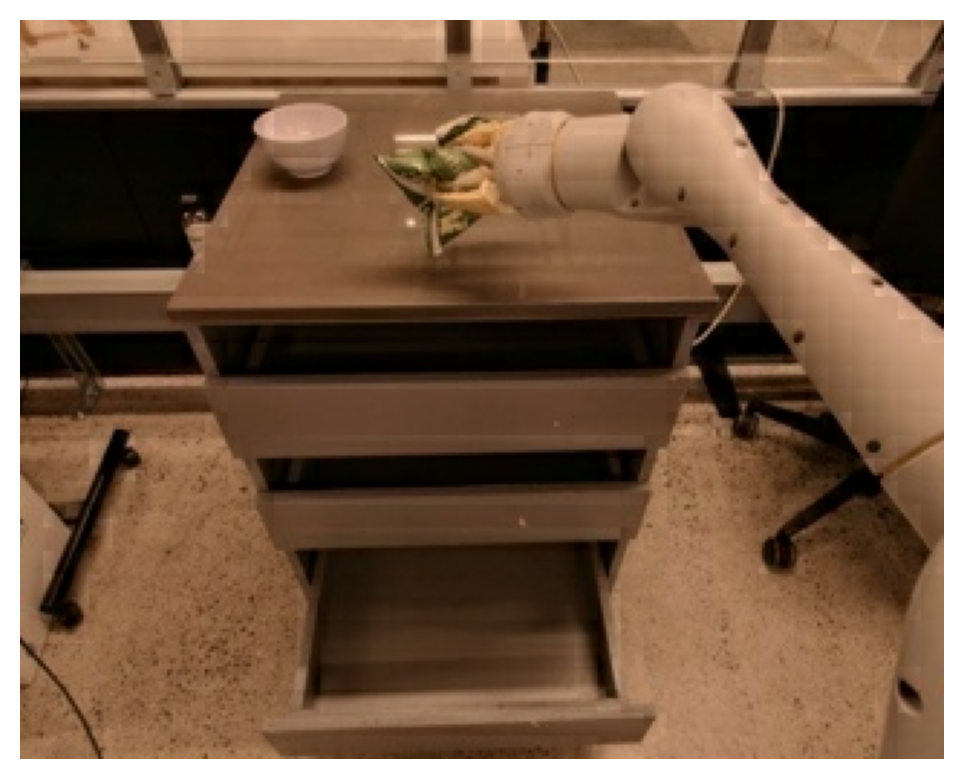

Done.


In [86]:
# G -> B -> R

idx = 60
assert idx < len(frames)

sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,2],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = env.joint_names[:-2] # Except fingers

env.reset(step=True)

q0 = q_traj[idx]
env.forward(q=q0,joint_names=env.joint_names[:-2]) # initial position

p0 = env.get_p_body(body_name='tcp_link')
R0 = env.get_R_body(body_name='tcp_link')

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

arr2image(frames[idx])

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = np.append(np.append(qpos,xyzrpyg[6]),xyzrpyg[6]),
        joint_names = joint_names+['joint_finger_right','joint_finger_left'])
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='base_link'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base_link')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print("Done.")  

# Trajectory Reappearance


In [87]:
joint_names = env.joint_names[:-2]

q0 = np.array( [-0.2639457174606611,
                0.0831913360274175,
                0.5017611504652179,
                1.156859026208673,
                0.028583671314766423,
                1.592598203487462,
                -1.080652960128774])

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
    
# Loop
q_ik_init = q0.copy()
qpos = q_traj[0]
idx = 0
gripper = gripper_states[0]
# append two gripper states to qpos
qpos = np.append(qpos, [gripper, gripper])

while env.is_viewer_alive():
    env.forward(q=qpos,joint_names=joint_names+['joint_finger_right','joint_finger_left'])

    # Render 
    if env.loop_every(HZ=0.2):
        if idx < len(q_traj)-1:
            idx += 1
        else: idx = 0

        qpos = q_traj[idx]
        gripper = gripper_states[idx]
        qpos = np.append(qpos, [gripper, gripper])
        gt_ee_pos = base_tool_poses[idx][:3].numpy()
        gt_ee_rot = quat2r(base_tool_poses[idx][3:].numpy())

        env.plot_T(
            T=env.get_T_body(body_name='base_link'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base_link')+np.array([0,0,0.5]),
            label = 'tick:[%d]time:[%.2f]'%(idx, env.get_sim_time()))
        env.plot_T(
            p=gt_ee_pos,R=gt_ee_rot,axis_len=0.1,print_xyz=False,plot_sphere=True,sphere_rgba=[0,1,1,0.5])
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

Done.


# Reverse Engineering


In [69]:
# current link gripper -> tcp_link rpy 0,0,0
# target link gripper -> target rpy

target = base_tool_poses[idx-1][3:]
target = quat2r(target)

base = env.get_R_body(body_name='link_gripper')
current = env.get_R_body(body_name='tcp_link')

R = current.T@base
rpy = r2rpy(R)
# print(rpy)

R = base.T@target
rpy = r2rpy(R)
# print(rpy)
print(rpy2quat(rpy))


'''
[-5.27306031e-17  9.32701387e-17  1.57079633e+00]
[ 1.48438446e-03  1.39833212e-01 -1.50792732e+00]
[ 0.72716463  0.04836099  0.05041956 -0.68289874]
[ 0.70710678  0.          0.         -0.70710678]


[9.99735615e-01 2.21498574e-02 9.10323765e-04 6.10366593e-03]
'''

[0.81599899 0.07140578 0.274555   0.50365307]


'\n[-5.27306031e-17  9.32701387e-17  1.57079633e+00]\n[ 1.48438446e-03  1.39833212e-01 -1.50792732e+00]\n[ 0.72716463  0.04836099  0.05041956 -0.68289874]\n[ 0.70710678  0.          0.         -0.70710678]\n\n\n[9.99735615e-01 2.21498574e-02 9.10323765e-04 6.10366593e-03]\n'